### Analysis of scRNA-seq of Etv2 reprogramming

In [70]:
library(SummarizedExperiment)
library(RColorBrewer)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)

Loading required package: GenomicFeatures
Loading required package: AnnotationDbi

Attaching package: ‘AnnotationDbi’

The following object is masked from ‘package:dplyr’:

    select




Read the processed scRNA-seq data (~2.1G)
The scRNA-seq dataset was prepared in scRNA_seq_preprocess.Rmd

In [37]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/garry_projects/etv2_pioneer/processed_Etv2_scRNAseq.rds')))

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

Determine the number of clusters by running k-means on the scVI latent space

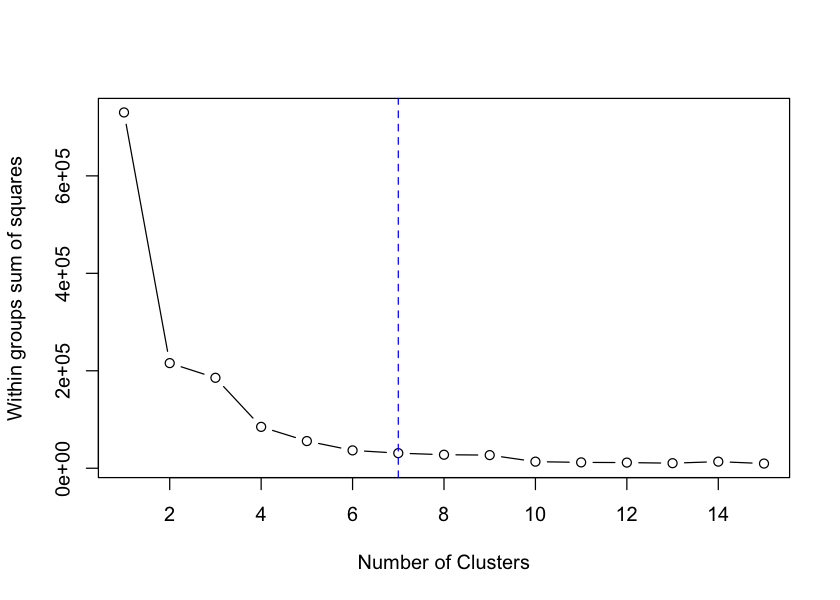

In [38]:
wss <- (nrow(colData(se)$umap)-1) * sum(apply(colData(se)$umap, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(colData(se)$umap,centers = i)$withinss)
options(repr.plot.width=7, repr.plot.height=5)
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
n_cluster <- 7
abline(v = n_cluster, col = 'blue', lty = 2)

Visulize cell clusters

In [54]:
colData(se)$group <- colData(se)$group %>% factor(c('MEF_Dox_D1', 'MEF_NoDox', 'MEF_Dox_D2', 'MEF_Dox_D7a', 'MEF_Dox_D7b'))
se
set.seed(1)
cls <- kmeans(colData(se)$umap, n_cluster, nstart = 100)$cluster
table(cls, colData(se)$group)
cls <- as.numeric(factor(cls, c(4,5,3,2,1,7,6)))
table(cls, colData(se)$group)

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

   
cls MEF_Dox_D1 MEF_NoDox MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1          1         0         17        1493           3
  2          0         6       1443           1           0
  3          0         4       1435          23           0
  4       2878       541         21           2           3
  5        657       381          1           0           0
  6          0         2          0           1         813
  7         26        14         19        5682           8

   
cls MEF_Dox_D1 MEF_NoDox MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1       2878       541         21           2           3
  2        657       381          1           0           0
  3          0         4       1435          23           0
  4          0         6       1443           1           0
  5          1         0         17        1493           3
  6         26        14         19        5682           8
  7          0         2          0           1         813

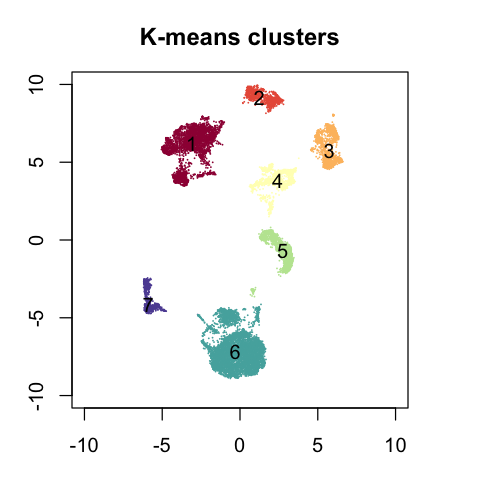

In [55]:
colData(se)$cluster <- cls
group2bg <- c(
   'MEF_Dox_D1' = 'black',
   'MEF_NoDox' = 'blue',
   'MEF_Dox_D2' = 'purple',
   'MEF_Dox_D7a' = 'red',
   'MEF_Dox_D7b' = 'pink'
 )
options(repr.plot.width=4, repr.plot.height=4)
par(mar = c(3, 3, 3, 3))
plot(
   colData(se)$umap,
   col = colorRampPalette(brewer.pal(11,'Spectral'))(n_cluster)[colData(se)$cluster],
   pch = 16, asp = 1, cex = 0.2,
   main = 'K-means clusters', xlab = '', ylab = '',
   xlim = c(-10, 10), ylim = c(-10, 10)
)
y_centers <- do.call('rbind', lapply(1:n_cluster, function(i) apply(colData(se)$umap[colData(se)$cluster == i, ], 2, median)))
text(y_centers[, 1], y_centers[, 2], 1:n_cluster, cex = 1)

Figure of cell sources (e.g. time points)

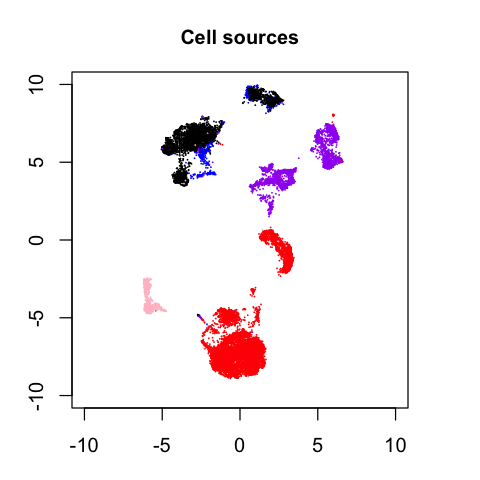

In [56]:
options(repr.plot.width=4, repr.plot.height=4)
par(mar = c(3, 3, 3, 3))
bg <- group2bg[colData(se)$group]
plot(colData(se)$umap, col = bg, asp = 1, pch = 16,  main = 'Cell sources', xlab = '', ylab = '', cex = 0.2, cex.main = 1, cex.axis = 1, xlim = c(-10, 10), ylim = c(-10, 10))

In [ ]:
Expresson plot of a set of genes

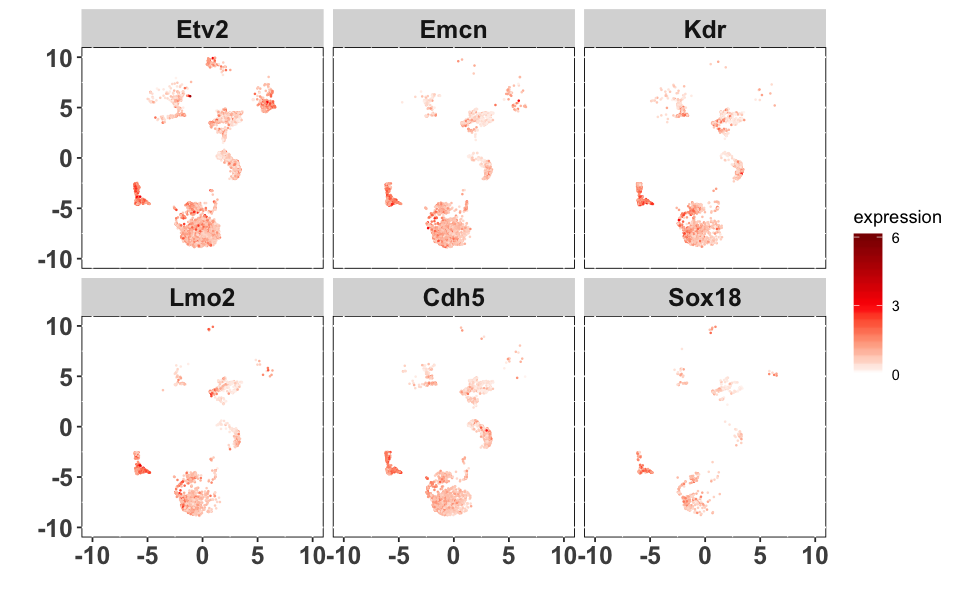

In [59]:
X <- assays(se)$normalized_counts
rownames(X) <- rowData(se)$name
gs <- c(
   'Etv2', 'Emcn', 'Kdr', 'Lmo2', 'Cdh5', 'Sox18'
)
d <- do.call('rbind', lapply(gs, function(g){
   x <- X[g, ]
   m <- which(x > 0.1)
   data.frame(gene = g, x = colData(se)$umap[m, 1], y = colData(se)$umap[m, 2], expression = x[m])
}))

b <- c(0, 3, 6)
options(repr.plot.width=8, repr.plot.height=5)
ggplot(d, aes(x = x, y = y, color = expression)) + geom_point(size = 0.25, shape = 20) +
   scale_color_gradientn(limits = c(0, max(b)), colours=c("white", "red", "darkred"), breaks=b, labels=format(b)) +
   theme(panel.background = element_rect(fill = 'white', colour = 'black')) +
   xlab('') + ylab('') +
   facet_wrap(~ gene, ncol = 3) +
   theme(strip.text.x = element_text(size = 15, face = 'bold')) +
   theme(axis.text = element_text(size = 15, face = 'bold')) +
   xlim(-10, 10) + ylim(-10, 10)

Identify the up-regulated genes in each cluster by using t-test on the scaled gene expression levels.
This step takes a few mins to finish.

In [61]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
h <- 7 # Flk1+ cell cluster
pvalues <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, clust == h], X[i, clust != h], alternative = 'greater')$p.value,
  mc.cores = 4) %>% unlist()
head(pvalues)

[1] 1.000000000 0.999999669 0.760553860 1.000000000 0.997500270 0.002978139

Pathway analysis of highly expressed genes in each cluster
Create a list of signifiant genes up-regulated in each cluster, fit the Probability Weighting Function (PWF) and find the significantly enriched GO terms.

In [ ]:
genes <- as.integer(pvalues < 1e-10)
names(genes) <- rowData(se)$name
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

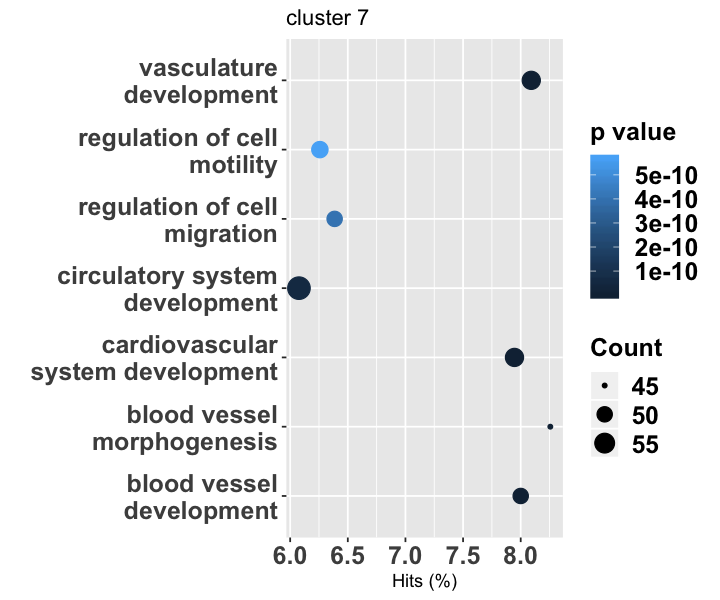

In [74]:
options(repr.plot.width=6, repr.plot.height=5)
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(7, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 20)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = sprintf('cluster %d', h), x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15, face = 'bold')) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold'))

In [75]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.2

Matrix products: default
BLAS/LAPACK: /Users/gongx030/anaconda3/envs/r/lib/libopenblasp-r0.3.7.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Mm.eg.db_3.10.0                      
 [2] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [3] GenomicFeatures_1.38.1                   
 [4] AnnotationDbi_1.48.0                     
 [5] rtracklayer_1.46.0                       
 [6] stringr_1.4.0                            
 [7] goseq_1.38.0                             
 [8] geneLenDataBase_1.22.0                   
 [9] BiasedUrn_1.07                           
[10] ggplot2_3.2.1                            
[11] dplyr_0.8.4                              
[12] RColorBrewer_1.1-2                      